# Function Approximation using Neural Networks (from scratch)

### Using Stochastic Gradient Descent and Momentum update rule

### Importing necessary libraries

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

### Loading Data

In [8]:
with open("train_fa.txt") as f:
    traintext = f.readlines()
    
with open("val_fa.txt") as f:
    valtext = f.readlines()

In [9]:
M = len(traintext)
Mtest = len(valtext)
X_train = np.zeros((M, 2))
y_train = np.zeros((M, 1))
X_test = np.zeros((Mtest, 2))
y_test = np.zeros((Mtest, 1))

In [10]:
for i in range(len(traintext)):
    temp = [float(num) for num in traintext[i][:-1].split()]
    X_train[i] = np.array(temp[:2])
    y_train[i] = temp[2]
    
for i in range(len(valtext)):
    temp = [float(num) for num in valtext[i][:-1].split()]
    X_test[i] = np.array(temp[:2])
    y_test[i] = temp[2]

### Normalization of the Data

In [51]:
X_train_mean = np.mean(X_train, axis=0).reshape((1,2))
X_train_std = np.std(X_train, axis=0).reshape((1, 2))
y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)

X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std
y_train_norm = (y_train - y_train_mean)/y_train_std
y_test_norm = (y_test - y_train_mean)/y_train_std

### No. of nodes in the input/output layers

In [12]:
input_nodes = 2
output_nodes = 1

### Activation functions and their Derivatives

In [13]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    # x is the tanh value
    return (1 - (np.tanh(x)**2))

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

### Loss Function

In [14]:
def squarederrorloss(y_hat, y):
    return (y_hat-y)**2

### Initialization

In [107]:
def initialize_parameters(layer_dims):
    np.random.seed(42)
    parameters = {}
    previous_updates = {}
    for l in range(1, len(layer_dims)):
        parameters["W"+str(l)] = np.random.rand(layer_dims[l], layer_dims[l-1])
        parameters["b"+str(l)] = np.zeros((layer_dims[l], 1))
        previous_updates["W"+str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
        previous_updates["b"+str(l)] = np.zeros((layer_dims[l], 1))
    return parameters, previous_updates

### Forward Propagation

In [108]:
def forward_propagation(X, parameters, activation='sigmoid'):
    L = len(parameters)//2 # number of layers
    A = [None]*(L+1)
    Z = [None]*(L+1)
    A[0] = X.reshape((2, 1))# A[0] stores the input training example
    
    for l in range(1, L + 1):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        Z[l] = np.dot(W, A[l-1]) + b
        if l == L:
            A[l] = Z[l]# Activation function at the output layer is the identity function
        else:
            if activation == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L]
    
    return output, A, Z

### Backpropagation

In [31]:
def backpropagation(y_hat, y, A, Z, parameters, activation='sigmoid'):
    gradients = {}
    L = len(parameters)//2 # number of layers
    y = y.reshape(y_hat.shape)
    
    # Initializing the backpropagation
    dAL = 2*(y_hat-y)
    dZL = 2*(y_hat-y)
    dWL = np.dot(dZL, A[L-1].T)
    dbL = dZL
    
    gradients["dA"+str(L)] = dAL
    gradients["dZ"+str(L)] = dZL
    gradients["dW"+str(L)] = dWL
    gradients["db"+str(L)] = dbL
    
    for l in reversed(range(1, L)):
        gradients["dA"+str(l)] = np.dot(parameters["W"+str(l+1)].T, gradients["dZ"+str(l+1)])
        if activation == 'tanh':
            gradients["dZ"+str(l)] = gradients["dA"+str(l)] * tanh_derivative(Z[l])
        else:
            gradients["dZ"+str(l)] = gradients["dA"+str(l)] * sigmoid_derivative(Z[l])
        gradients["dW"+str(l)] = np.dot(gradients["dZ"+str(l)], A[l-1].T)
        gradients["db"+str(l)] = gradients["dZ"+str(l)]
        
    return gradients

### Parameter Update (Generalized Delta Rule)

In [35]:
def parameter_update_with_momentum(parameters, gradients, learning_rate, beta, previous_updates):
    L = len(parameters)//2 # number of layers
    
    for l in range(1, L+1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*gradients["dW"+str(l)]
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*gradients["db"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate*previous_updates["b"+str(l)]
    
    return parameters, previous_updates

### Plotting training and validation loss curves

In [19]:
def plot_loss_curve(train_loss, val_loss):
    print()
    plt.plot(list(range(len(train_loss))), train_loss, 'r', label="Training loss")
    plt.plot(list(range(len(val_loss))), val_loss, 'lime', label="Validation loss")
    plt.title("Training Loss vs Number of Epochs", size=18)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

### Building the Model

In [141]:
def NN_model(X_train, y_train, X_test, y_test, layer_dims, learning_rate=0.001, beta=0.9, max_epochs=500, activ='sigmoid'):
    parameters, previous_updates = initialize_parameters(layer_dims)
    
    epoch_cost = [] # average training cost at the end of every epoch
    
    prev_epoch_cost = 1000 # some large initial value
    curr_epoch_cost = 0
    
    validation_epoch_cost = [] # average validation cost at the end of every epoch
    
    count=1 # keeps track of the number of epochs
    # An epoch is one complete pass through the training data
    
    #while abs(prev_epoch_cost-curr_epoch_cost) > 1e-7 and count<=max_epochs:
    while count<=max_epochs:
        costs = []# training costs
        val_costs = []# validation costs
        count+=1# increment the number of epochs
        for i in range(len(X_train)):
            output, A, Z = forward_propagation(X_train[i], parameters, activation=activ)
            cost = squarederrorloss(output, y_train[i])
            gradients = backpropagation(output, y_train[i], A, Z, parameters, activation=activ)
            parameters, previous_updates = parameter_update_with_momentum(
                                                                parameters, gradients, learning_rate, beta,
                                                                previous_updates)
            costs.append(cost)
            
        # vaidation part (these examples do not contribute to parameter update)
        # therefore, the 'model' has still not seen these examples.
        for j in range(len(X_test)):
            out, _, _ = forward_propagation(X_test[j], parameters)
            cost = squarederrorloss(output, y_test[j])
            val_costs.append(cost)
            
        # average training loss for one epoch
        curr_epoch_cost = sum(costs)/len(X_train)
        if len(epoch_cost) >= 1:
            prev_epoch_cost = epoch_cost[-1]
        epoch_cost.append(np.squeeze(curr_epoch_cost))
        
        # average validation loss for one epoch
        validation_epoch_cost.append(np.squeeze(sum(val_costs)/len(X_test)))
        
    plot_loss_curve(epoch_cost, validation_epoch_cost)
    print("Number of epochs = ", count)
    return parameters, epoch_cost, validation_epoch_cost

### Predictions and performance metrics

In [187]:
def predict(X, parameters, activation='sigmoid'):
    # X here is one training example
    pred, _, _ = forward_propagation(X, parameters, activation=activation)
    return pred

def predictions(X, parameters, activation='sigmoid'):
    # X is an array of many training examples
    y_pred = np.zeros(len(X))
    X_norm = (X - X_train_mean)/X_train_std
    for i in range(len(X_norm)):
        y_pred[i] = predict(X_norm[i], parameters, activation=activation)
        
    y_pred_scaledup = y_pred*y_train_std + y_train_mean
    return y_pred_scaledup
        
def model_mse(predictions, y_truth):
    return np.mean((predictions.reshape(y_truth.shape) - y_truth)**2)

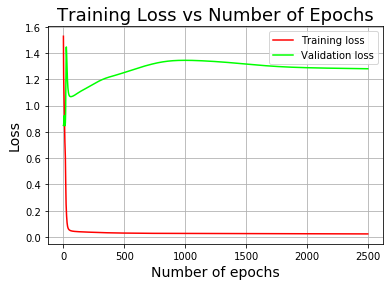

Number of epochs =  2501
Training MSE loss = 24.131
Test MSE loss = 55.101


In [207]:
layer_dims = [input_nodes, 10, 8, output_nodes]
activation_function = 'sigmoid'
parameters, epoch_cost, validation_epoch_cost = NN_model(X_train_norm, y_train_norm, 
                                                         X_test_norm, y_test_norm, layer_dims, 
                                                          learning_rate=0.05, beta=0.8, 
                                                         max_epochs=2500, activ=activation_function)
y_pred_train = predictions(X_train, parameters)
print("Training MSE loss = {}".format(round(model_mse(y_pred_train, y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test MSE loss = {}".format(round(model_mse(y_pred_test, y_test), 3)))

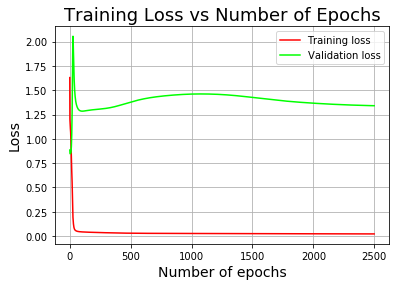

Number of epochs =  2501
Training MSE loss = 24.498
Test MSE loss = 55.868


In [208]:
layer_dims = [input_nodes, 10, 8, output_nodes]
activation_function = 'sigmoid'
parameters, epoch_cost, validation_epoch_cost = NN_model(X_train_norm, y_train_norm, 
                                                         X_test_norm, y_test_norm, layer_dims, 
                                                          learning_rate=0.05, beta=0.9, 
                                                         max_epochs=2500, activ=activation_function)
y_pred_train = predictions(X_train, parameters)
print("Training MSE loss = {}".format(round(model_mse(y_pred_train, y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test MSE loss = {}".format(round(model_mse(y_pred_test, y_test), 3)))

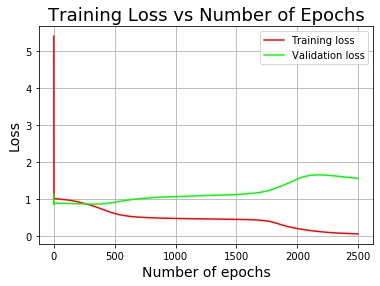

Number of epochs =  2501
Training MSE loss = 68.038
Test MSE loss = 83.405


In [209]:
layer_dims = [input_nodes, 10, 8, output_nodes]
activation_function = 'sigmoid'
parameters, epoch_cost, validation_epoch_cost = NN_model(X_train_norm, y_train_norm, 
                                                         X_test_norm, y_test_norm, layer_dims, 
                                                          learning_rate=0.001, beta=0.9, 
                                                         max_epochs=2500, activ=activation_function)
y_pred_train = predictions(X_train, parameters)
print("Training MSE loss = {}".format(round(model_mse(y_pred_train, y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test MSE loss = {}".format(round(model_mse(y_pred_test, y_test), 3)))

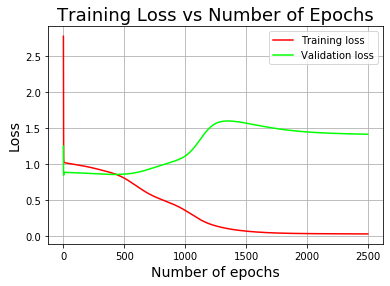

Number of epochs =  2501
Training MSE loss = 38.543
Test MSE loss = 44.047


In [210]:
layer_dims = [input_nodes, 5, 5, output_nodes]
activation_function = 'sigmoid'
parameters, epoch_cost, validation_epoch_cost = NN_model(X_train_norm, y_train_norm, 
                                                         X_test_norm, y_test_norm, layer_dims, 
                                                          learning_rate=0.001, beta=0.9, 
                                                         max_epochs=2500, activ=activation_function)
y_pred_train = predictions(X_train, parameters)
print("Training MSE loss = {}".format(round(model_mse(y_pred_train, y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test MSE loss = {}".format(round(model_mse(y_pred_test, y_test), 3)))

In [214]:
print("RMSE/SD deviation value for training set = ",38.543**0.5/y_train_std)
print("RMSE/SD deviation value for test set = ",44.047**0.5/y_train_std)

RMSE/SD deviation value for training set =  0.1805644211316254
RMSE/SD deviation value for test set =  0.19302679049220606


### Model Output vs Desired Output

#### Training Data

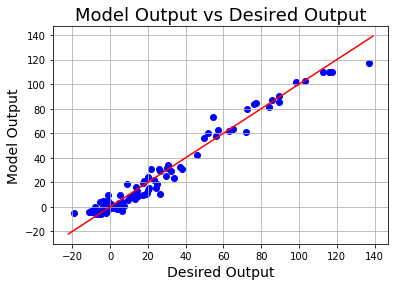

In [249]:
plt.scatter(y_train, y_pred_train, color='blue')
plt.plot(range(-22, 140), range(-22, 140), c='r')
plt.xlabel("Desired Output", size=14)
plt.ylabel("Model Output", size=14)
plt.title("Model Output vs Desired Output", size=18)
plt.grid()
plt.show()

#### Validation Data

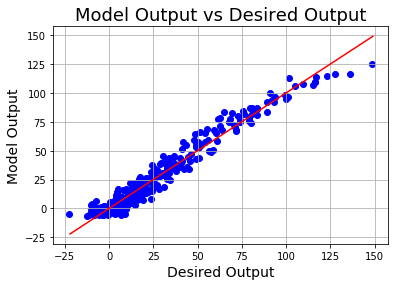

In [251]:
plt.scatter(y_test, y_pred_test, color='blue')
plt.plot(range(-22, 150), range(-22, 150), c='r')
plt.xlabel("Desired Output", size=14)
plt.ylabel("Model Output", size=14)
plt.title("Model Output vs Desired Output", size=18)
plt.grid()
plt.show()

### Approximated Function

In order to plot the function approximated by the model, I will create a meshgrid of points on the x, y plane and predict the function value at each of them and use these function values to plot a surface contour plot.

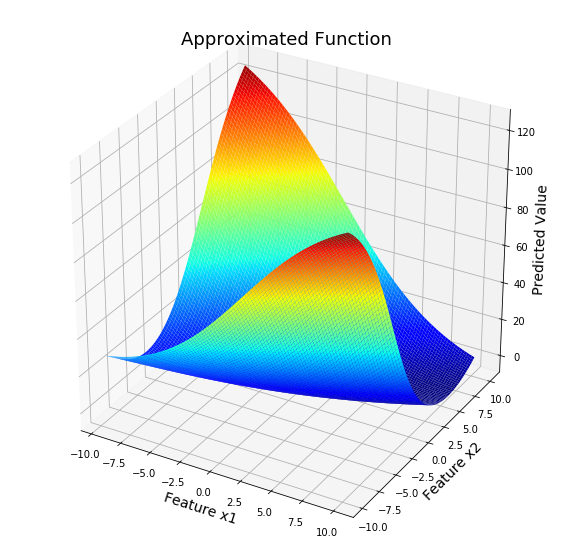

In [288]:
h = .2  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 0.25, X_train[:, 0].max() + 0.25
y_min, y_max = X_train[:, 1].min() - 0.25, X_train[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

p = predictions(np.c_[xx.ravel(), yy.ravel()], parameters)

Z = p.reshape(xx.shape)


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
ax.set_title('Approximated Function', size=18)
ax.set_xlabel('Feature x1', size=14)
ax.set_ylabel('Feature x2', size=14)
ax.set_zlabel('Predicted Value', size=14)
plt.show()

### Desired Function
To plot the desired function, I will use the given data points along with their labels and use the triangulation method to get an estimate of the shape of the desired function given the data points.

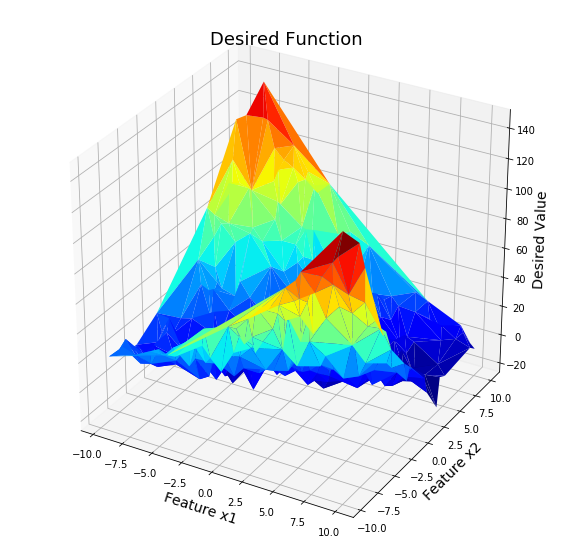

In [289]:
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)
triang = matplotlib.tri.Triangulation(X[:, 0], X[:, 1])
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_trisurf(triang,np.squeeze(y), cmap='jet')
ax.set_xlabel('Feature x1', size=14)
ax.set_ylabel('Feature x2', size=14)
ax.set_zlabel('Desired Value', size=14)
ax.set_title('Desired Function', size=18)
plt.show()